Optimized parameters:
  k = 6.5294
  a = 8.7458
  b = 7.6193
  Minimum Sum of Squared Errors: 279.6991


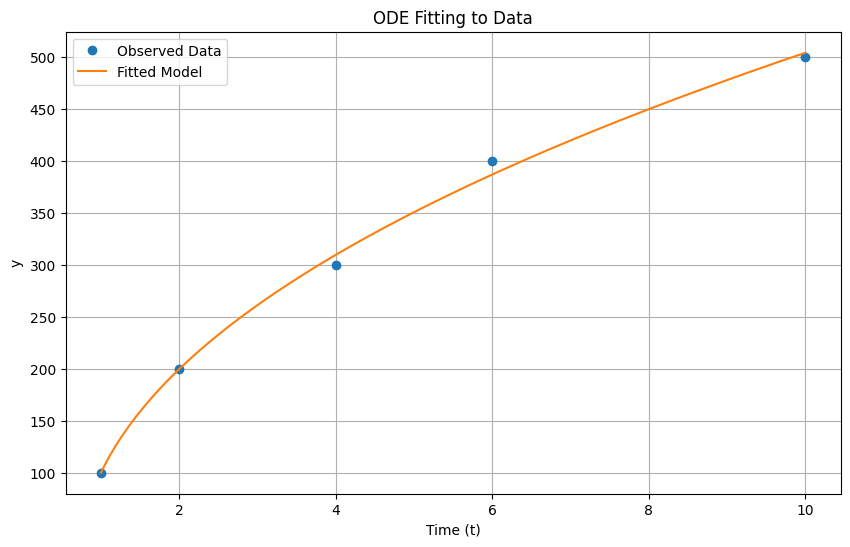

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. 微分方程式の定義
# solve_ivpは (t, y, *args) の形式で関数を受け取る
def model_ode(t, y, k, a, b):
    # yは配列だが、このケースでは単一の値なので y[0] を使う
    dydt = k * ((1.0 / y[0])**a) * ((3.0 * y[0])**b)
    return [dydt]

# 観測データ
t_data = np.array([1, 2, 4, 6, 10])
y_data = np.array([100, 200, 300, 400, 500])

# 2. 目的関数の定義
def objective_function(params, t_data, y_data):
    k, a, b = params

    # フィッティングの初期値は、観測データの最初のy値とする
    # 微分方程式はyが0に近付くと問題が生じる可能性があるため、
    # 実際の問題に応じて適切な初期値とyの範囲を考慮する必要があります。
    y0 = [y_data[0]]

    # solve_ivpを使って微分方程式を解く
    # t_spanはデータの最初の時刻から最後の時刻まで
    # t_evalはデータ点の時刻と一致させる
    sol = solve_ivp(
        model_ode,
        (t_data[0], t_data[-1]),
        y0,
        args=(k, a, b),
        t_eval=t_data,  # 観測データのある時刻で評価
        method='LSODA', # 剛性の高いODEにも対応できるソルバーを選択
        dense_output=True # dense_output=True で補間関数を得られるが、t_evalを使う場合は必須ではない
    )

    # 積分が成功したかチェック
    if not sol.success:
        print(f"Integration failed for k={k}, a={a}, b={b}: {sol.message}")
        # 積分が失敗した場合は、非常に大きな誤差を返す
        return np.inf

    # モデルの予測値と観測データとの二乗誤差を計算
    # sol.y[0] は、解の最初の変数（今回の場合はy）の予測値の配列
    y_predicted = sol.y[0]

    # モデルの予測値の長さがデータ点の長さと一致するか確認
    if len(y_predicted) != len(y_data):
        print(f"Warning: Length mismatch. Predicted: {len(y_predicted)}, Data: {len(y_data)}")
        # 予測値がデータ点に完全に合致しない場合は、補間が必要になることもある
        # 今回はt_eval=t_dataとしているので、通常は一致するはず
        # ここでは、一致しない場合にエラーとして非常に大きな誤差を返す
        return np.inf

    error = np.sum((y_predicted - y_data)**2)
    return error

# 3. 最適化アルゴリズムの利用
# k, a, bの初期推測値
# 初期値はフィッティングの成否に大きく影響するため、慎重に選ぶ必要があります。
# 物理的な洞察や、簡単な手計算などからあたりをつけると良いでしょう。
initial_guess = [1.0, 0.5, 0.5] # k, a, b の初期値

# 最小化を実行
# method='Nelder-Mead' は導関数が不要なシンプルなメソッド
# method='L-BFGS-B' や 'TNC' は境界制約を扱える
# boundsを使ってパラメータに制約を設けることも可能 (例: k > 0, a > 0 など)
# bounds = ((0.001, None), (0.001, None), (0.001, None)) # k,a,b は正の値
# result = minimize(objective_function, initial_guess, args=(t_data, y_data), method='L-BFGS-B', bounds=bounds)

result = minimize(objective_function, initial_guess, args=(t_data, y_data), method='Nelder-Mead')


# フィッティング結果の表示
if result.success:
    k_opt, a_opt, b_opt = result.x
    print(f"Optimized parameters:")
    print(f"  k = {k_opt:.4f}")
    print(f"  a = {a_opt:.4f}")
    print(f"  b = {b_opt:.4f}")
    print(f"  Minimum Sum of Squared Errors: {result.fun:.4f}")

    # 最適化されたパラメータを使ってモデルを再評価し、プロット
    # より細かい時間点で解を計算して滑らかな曲線を描く
    t_plot = np.linspace(t_data[0], t_data[-1], 200)
    y0_fit = [y_data[0]] # フィッティングされたモデルの初期値
    sol_fit = solve_ivp(
        model_ode,
        (t_plot[0], t_plot[-1]),
        y0_fit,
        args=(k_opt, a_opt, b_opt),
        t_eval=t_plot,
        method='LSODA'
    )

    plt.figure(figsize=(10, 6))
    plt.plot(t_data, y_data, 'o', label='Observed Data')
    plt.plot(sol_fit.t, sol_fit.y[0], '-', label='Fitted Model')
    plt.title('ODE Fitting to Data')
    plt.xlabel('Time (t)')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Optimization failed:", result.message)